
# Customer Segmentation & Predictive Modeling

This notebook reproduces the workflow and visual style of dataset:
- Data ingestion & cleaning
- RFM feature engineering
- K-Means clustering (WCSS/elbow + silhouette)
- Cluster visualizations (histograms, heatmaps, PCA scatter, violin/strip plots)
- Predictive modeling: Random Forest & GBT with CV fallback, ROC curves and confusion matrices

**Before running:** install dependencies if needed:
```bash
pip install pyspark==4.0.0 pandas>=2.0.0 pyarrow matplotlib seaborn scikit-learn plotly
```


# 1) Imports & Spark session

In [1]:
import sys, warnings, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (8, 4.6)
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["lines.linewidth"] = 2.0

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col, when, isnan, count, to_date, datediff, lit, countDistinct, max as spark_max, log
from pyspark.sql.types import IntegerType, DoubleType, StringType

from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.functions import vector_to_array

from pyspark.ml.classification import RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import plotly.graph_objs as go
import plotly.offline as py

import pyspark, pyarrow
print("Python:", sys.version.split()[0])
print("PySpark:", pyspark.__version__)
print("PyArrow:", pyarrow.__version__)
print("Pandas:", pd.__version__)

# Warn if pandas version < 2.0 (Spark 4 recommends pandas >=2.0)
from packaging import version
if version.parse(pd.__version__) < version.parse("2.0.0"):
    warnings.warn("Pandas >= 2.0.0 is recommended for Spark 4.0.0. Please upgrade pandas for best compatibility.")

# Start Spark session (minimal local settings)
spark = SparkSession.builder \
    .appName("Customer Segmentation - Spark 4.0.0") \
    .master("local[*]") \
    .config("spark.sql.shuffle.partitions", "300") \
    .config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
    .getOrCreate()

# Enable Arrow for toPandas
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

print("Spark session version:", spark.version)


Python: 3.10.9
PySpark: 4.0.0
PyArrow: 21.0.0
Pandas: 2.3.1
Spark session version: 4.0.0


# 2) Load data

In [2]:
data_path = "OnlineRetail.csv"  # <-- change to your path
data = spark.read.csv(data_path, header=True, inferSchema=True)

print("Rows:", data.count(), " | Cols:", len(data.columns))
data.printSchema()
data.show(5, truncate=False)


Rows: 541909  | Cols: 8
root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)

+---------+---------+-----------------------------------+--------+--------------+---------+----------+--------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate   |UnitPrice|CustomerID|Country       |
+---------+---------+-----------------------------------+--------+--------------+---------+----------+--------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |12/1/2010 8:26|2.55     |17850     |United Kingdom|
|536365   |71053    |WHITE METAL LANTERN                |6       |12/1/2010 8:26|3.39     |17850     |United Kingdom|
|536365   |84406B   |CREAM CUPID HEARTS COAT HAN

# 3) Missing values count + bar chart 

        column  missing_count
6   CustomerID         135080
2  Description           1454
0    InvoiceNo              0
1    StockCode              0
3     Quantity              0
4  InvoiceDate              0
5    UnitPrice              0
7      Country              0


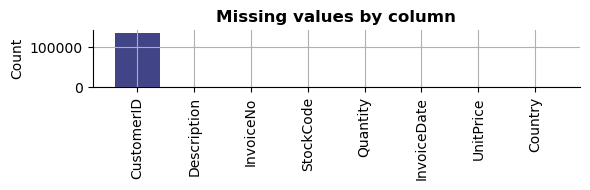

In [3]:
num_types = {"int", "bigint", "double", "float", "decimal", "smallint", "tinyint"}
missing_counts_df = data.select([
    count(when(((isnan(c) if t in num_types else None) | col(c).isNull()), c)).alias(c)
    for c, t in data.dtypes
])
missing_counts = missing_counts_df.collect()[0].asDict()
missing_pd = pd.DataFrame(list(missing_counts.items()), columns=["column", "missing_count"]).sort_values("missing_count", ascending=False)
print(missing_pd.head(10))

# Bar plot 
colors = ["#1f77b4"] * len(missing_pd)  # single-color bar, or change to a colormap
plt.figure(figsize=(6,2))
plt.bar(missing_pd["column"], missing_pd["missing_count"], color=plt.cm.viridis(np.linspace(0.2, 0.9, len(missing_pd))))
plt.xticks(rotation=90)
plt.title("Missing values by column")
plt.ylabel("Count")
plt.tight_layout()
plt.show()



# 4) Data cleaning: median for numerics, mode for categoricals, TotalPrice, InvoiceDate parse

In [4]:
# Numeric imputation (median)
numerical_cols = ["Quantity", "UnitPrice"]
for cn in numerical_cols:
    if cn in [c for c,_ in data.dtypes]:
        dtype = dict(data.dtypes)[cn]
        if dtype in ("int", "bigint", "double", "float", "decimal", "smallint", "tinyint"):
            median_val = data.approxQuantile(cn, [0.5], 0.01)[0]
            if median_val is not None:
                data = data.fillna({cn: float(median_val)})

# Categorical imputation (mode)
categorical_cols = ["InvoiceNo", "StockCode", "Description", "CustomerID", "Country"]
for cn in categorical_cols:
    if cn in [c for c,_ in data.dtypes]:
        mode_row = data.groupBy(cn).count().orderBy(F.desc("count")).first()
        if mode_row and mode_row[0] is not None:
            data = data.fillna({cn: str(mode_row[0])})

# TotalPrice
if set(["Quantity","UnitPrice"]).issubset(set(data.columns)):
    data = data.withColumn("TotalPrice", col("Quantity") * col("UnitPrice"))

# Parse InvoiceDate: try multiple common formats
if "InvoiceDate" in data.columns:
    data = data.withColumn("InvoiceDate_tmp", to_date(col("InvoiceDate"), "MM/dd/yyyy HH:mm"))
    data = data.withColumn("InvoiceDate",
                           F.coalesce(
                               col("InvoiceDate_tmp"),
                               to_date(col("InvoiceDate"), "dd/MM/yyyy HH:mm"),
                               to_date(col("InvoiceDate"), "yyyy-MM-dd HH:mm:ss"),
                               to_date(col("InvoiceDate"), "yyyy-MM-dd")
                           )).drop("InvoiceDate_tmp")

print("After cleaning - rows:", data.count(), " cols:", len(data.columns))
data.show(5, truncate=False)


After cleaning - rows: 541909  cols: 9
+---------+---------+-----------------------------------+--------+-----------+---------+----------+--------------+------------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate|UnitPrice|CustomerID|Country       |TotalPrice        |
+---------+---------+-----------------------------------+--------+-----------+---------+----------+--------------+------------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |2010-12-01 |2.55     |17850     |United Kingdom|15.299999999999999|
|536365   |71053    |WHITE METAL LANTERN                |6       |2010-12-01 |3.39     |17850     |United Kingdom|20.34             |
|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER     |8       |2010-12-01 |2.75     |17850     |United Kingdom|22.0              |
|536365   |84029G   |KNITTED UNION FLAG HOT WATER BOTTLE|6       |2010-12-01 |3.39     |17850     |United Kingdom|20.34             |
|536365   |84029E   |RE

# 5) RFM Feature Engineering

In [5]:
import datetime
reference_date = datetime.date(2011, 12, 10)

rfm = data.groupBy("CustomerID").agg(
    datediff(lit(reference_date), spark_max(col("InvoiceDate"))).alias("Recency"),
    countDistinct("InvoiceNo").alias("Frequency"),
    F.sum("TotalPrice").alias("Monetary")
).dropna(subset=["CustomerID"])

rfm = rfm.withColumn("Log_Frequency", log(col("Frequency") + lit(1.0))) \
         .withColumn("Log_Monetary", log(col("Monetary") + lit(1.0))) \
         .withColumn("RFM_Score", col("Recency") + col("Log_Frequency") + col("Log_Monetary"))

print("RFM rows:", rfm.count())
rfm.show(5, truncate=False)


RFM rows: 4372
+----------+-------+---------+------------------+------------------+-----------------+------------------+
|CustomerID|Recency|Frequency|Monetary          |Log_Frequency     |Log_Monetary     |RFM_Score         |
+----------+-------+---------+------------------+------------------+-----------------+------------------+
|15727     |17     |7        |5178.96           |2.0794415416798357|8.552552613215992|27.63199415489583 |
|16735     |79     |7        |2269.2100000000005|2.0794415416798357|7.727627617209785|88.80706915888963 |
|17389     |1      |43       |31300.08          |3.784189633918261 |10.3514078807253 |15.135597514643562|
|16386     |29     |2        |317.2             |1.0986122886681096|5.762680115903686|35.8612924045718  |
|16339     |285    |1        |109.95000000000002|0.6931471805599453|4.709079649378603|290.40222682993857|
+----------+-------+---------+------------------+------------------+-----------------+------------------+
only showing top 5 rows


# 6) RFM Distributions 

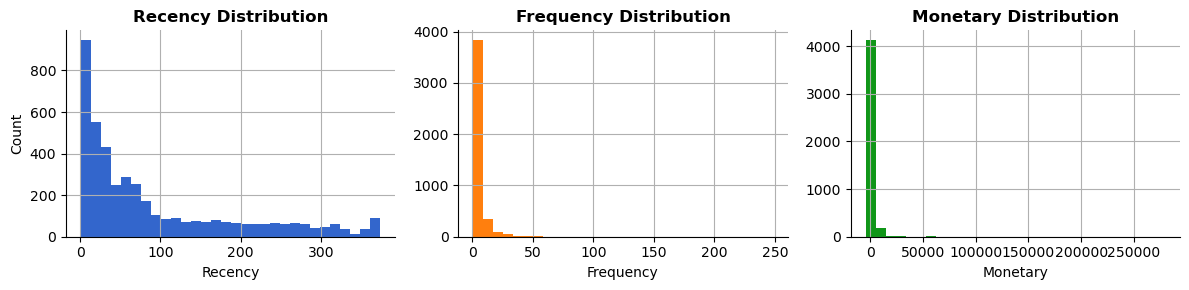

In [6]:
rfm_pd = rfm.select(
    "Recency", "Frequency", "Monetary", 
    "Log_Frequency", "Log_Monetary", "RFM_Score"
).limit(200000).toPandas()

fig, axes = plt.subplots(1, 3, figsize=(12, 3))

colors = ["#3366cc", "#ff7f0e", "#109618"]
cols = ["Recency", "Frequency", "Monetary"]
titles = ["Recency Distribution", "Frequency Distribution", "Monetary Distribution"]

for i, coln in enumerate(cols):
    axes[i].hist(rfm_pd[coln].dropna(), bins=30, color=colors[i])
    axes[i].set_title(titles[i])
    axes[i].set_xlabel(coln)
    if i == 0:
        axes[i].set_ylabel("Count")

plt.tight_layout()
plt.show()


# 7) Correlation heatmap 

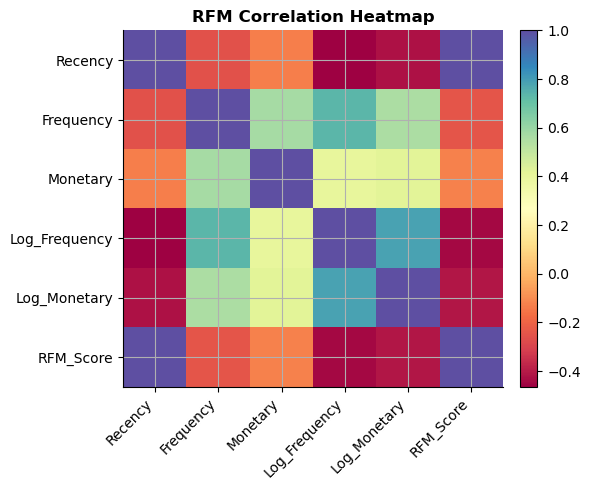

In [7]:
corr_cols = ["Recency","Frequency","Monetary","Log_Frequency","Log_Monetary","RFM_Score"]
corr = rfm_pd[corr_cols].corr()

plt.figure(figsize=(6,5))
im = plt.imshow(corr, cmap="Spectral", aspect="auto")
plt.xticks(range(len(corr_cols)), corr_cols, rotation=45, ha="right")
plt.yticks(range(len(corr_cols)), corr_cols)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("RFM Correlation Heatmap")
plt.tight_layout(); plt.show()


# 8) Assemble & Scale features

In [8]:
assembler = VectorAssembler(inputCols=["Recency","Log_Frequency","Log_Monetary","RFM_Score"], outputCol="features", handleInvalid="skip")
rfm_features = assembler.transform(rfm)

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
rfm_scaled = scaler.fit(rfm_features).transform(rfm_features)
rfm_scaled.select("scaledFeatures").show(5, truncate=False)


+---------------------------------------------------------------------------------+
|scaledFeatures                                                                   |
+---------------------------------------------------------------------------------+
|[-0.7454928237133478,0.8561341551635224,1.543214262081567,-0.7253559619457796]   |
|[-0.12000468470211244,0.8561341551635224,0.9070404906812365,-0.10268053221713874]|
|[-0.9069091176517312,3.1686997769663026,2.9304731586784354,-0.8525515419678823]  |
|[-0.6244306032595603,-0.4744037827878314,-0.6083070482605344,-0.6415933866870226]|
|[1.9582300997545727,-1.0244350009605319,-1.4208330179953224,1.949272022411334]   |
+---------------------------------------------------------------------------------+
only showing top 5 rows


# 9) K-Means evaluation across k: WCSS + Silhouette

In [9]:
def squared_euclidean_distance(point, center):
    return float(np.sum((np.array(point) - np.array(center)) ** 2))

k_values = list(range(2,11))
evaluation_metrics = []

for k in k_values:
    kmeans = KMeans(k=k, seed=42, featuresCol="scaledFeatures", predictionCol="cluster")
    kmodel = kmeans.fit(rfm_scaled)
    preds = kmodel.transform(rfm_scaled)
    centers = kmodel.clusterCenters()

    # compute WCSS with RDD to avoid collecting full DF
    wcss = preds.select("scaledFeatures","cluster").rdd.map(lambda r: squared_euclidean_distance(r["scaledFeatures"], centers[int(r["cluster"])] )).sum()

    evaluator_sil = ClusteringEvaluator(featuresCol="scaledFeatures", predictionCol="cluster", metricName="silhouette")
    sil = evaluator_sil.evaluate(preds)

    evaluation_metrics.append({"k": k, "WCSS": wcss, "Silhouette": sil})

metrics_df = pd.DataFrame(evaluation_metrics)
print(metrics_df)


    k         WCSS  Silhouette
0   2  9081.909224    0.658529
1   3  5332.152914    0.609288
2   4  4284.837585    0.532765
3   5  3509.772595    0.523621
4   6  3165.398223    0.516744
5   7  3005.434749    0.462033
6   8  2596.618015    0.465569
7   9  2395.501362    0.431887
8  10  2252.045612    0.413584


# 10) Elbow & Silhouette plots 

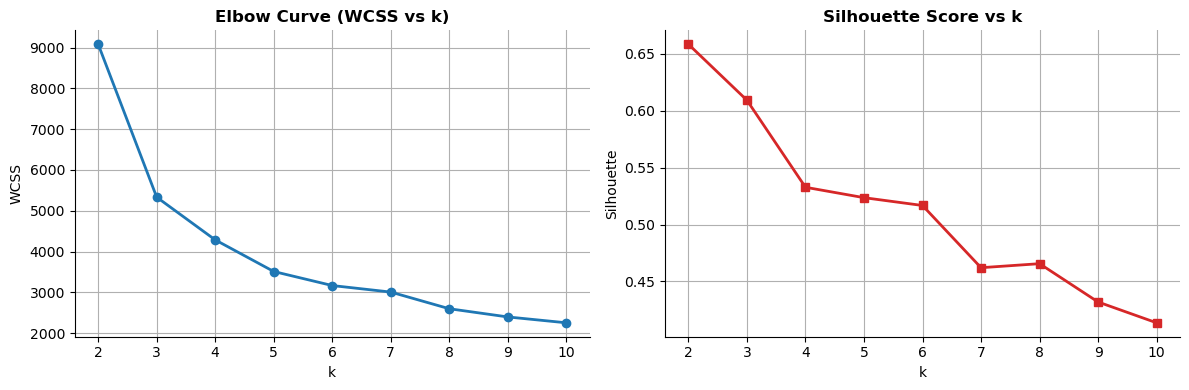

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Elbow curve
axes[0].plot(metrics_df["k"], metrics_df["WCSS"], marker="o", color="#1f77b4", linewidth=2)
axes[0].set_title("Elbow Curve (WCSS vs k)")
axes[0].set_xlabel("k")
axes[0].set_ylabel("WCSS")
axes[0].set_xticks(metrics_df["k"])

# Silhouette score
axes[1].plot(metrics_df["k"], metrics_df["Silhouette"], marker="s", color="#d62728", linewidth=2)
axes[1].set_title("Silhouette Score vs k")
axes[1].set_xlabel("k")
axes[1].set_ylabel("Silhouette")
axes[1].set_xticks(metrics_df["k"])

plt.tight_layout()
plt.show()


# 11) Fit best k and show cluster summary

In [11]:
best_k = int(metrics_df.loc[metrics_df["Silhouette"].idxmax(), "k"])
print("Best k by silhouette:", best_k)

kmeans = KMeans(k=best_k, seed=42, featuresCol="scaledFeatures", predictionCol="cluster")
kmodel = kmeans.fit(rfm_scaled)
rfm_clusters = kmodel.transform(rfm_scaled)

cluster_summary = rfm_clusters.groupBy("cluster").agg(
    F.count("*").alias("Count"),
    F.avg("Recency").alias("Avg_Recency"),
    F.avg("Log_Frequency").alias("Avg_Log_Frequency"),
    F.avg("Log_Monetary").alias("Avg_Log_Monetary"),
    F.avg("RFM_Score").alias("Avg_RFM_Score")
).orderBy("cluster")

cluster_summary.show(truncate=False)
cluster_summary_pd = cluster_summary.toPandas()


Best k by silhouette: 2
+-------+-----+------------------+------------------+-----------------+------------------+
|cluster|Count|Avg_Recency       |Avg_Log_Frequency |Avg_Log_Monetary |Avg_RFM_Score     |
+-------+-----+------------------+------------------+-----------------+------------------+
|0      |1172 |232.63993174061434|0.9327118914759706|5.585831941567239|239.15847557365774|
|1      |3159 |38.307375751820196|1.6396224303867786|6.909725629420331|46.85672381162729 |
+-------+-----+------------------+------------------+-----------------+------------------+



# 12) Cluster summary bar charts 

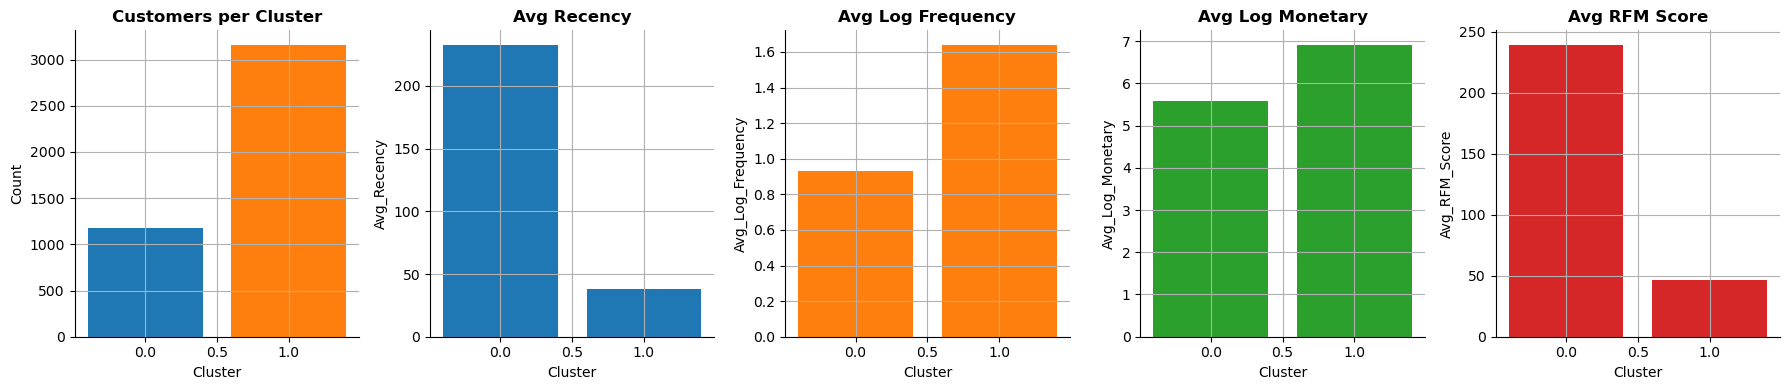

In [12]:
palette = ["#1f77b4","#ff7f0e","#2ca02c","#d62728",
           "#9467bd","#8c564b","#e377c2","#7f7f7f",
           "#bcbd22","#17becf"]

fig, axes = plt.subplots(1, 5, figsize=(18, 4))

# Customers per cluster
axes[0].bar(cluster_summary_pd["cluster"],
            cluster_summary_pd["Count"],
            color=[palette[int(i) % len(palette)] for i in cluster_summary_pd["cluster"]])
axes[0].set_title("Customers per Cluster")
axes[0].set_xlabel("Cluster"); axes[0].set_ylabel("Count")

# Metrics 
metrics = ["Avg_Recency","Avg_Log_Frequency","Avg_Log_Monetary","Avg_RFM_Score"]
colors  = ["#1f77b4","#ff7f0e","#2ca02c","#d62728"]

for i, (col_name, color) in enumerate(zip(metrics, colors), start=1):
    axes[i].bar(cluster_summary_pd["cluster"],
                cluster_summary_pd[col_name],
                color=color)
    axes[i].set_title(col_name.replace("_"," "))
    axes[i].set_xlabel("Cluster"); axes[i].set_ylabel(col_name)

plt.tight_layout()
plt.show()


# 13) PCA 2D scatter of clusters 

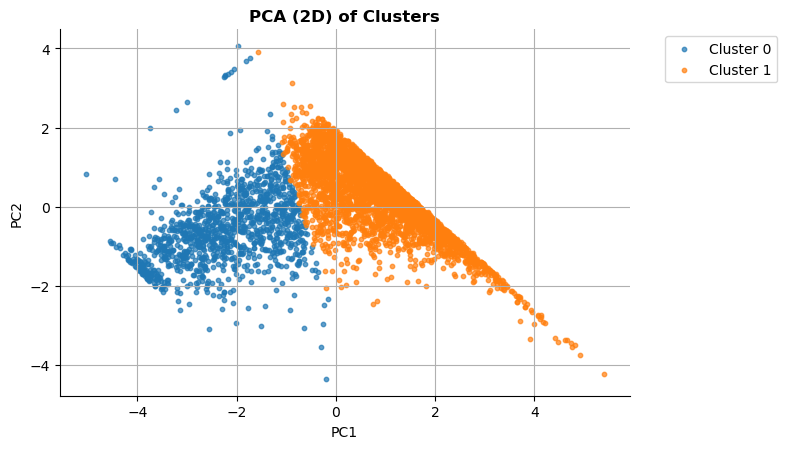

In [13]:
pca = PCA(k=2, inputCol="scaledFeatures", outputCol="pca2")
pca_model = pca.fit(rfm_clusters)
rfm_pca = pca_model.transform(rfm_clusters).withColumn("pc1", vector_to_array("pca2").getItem(0)).withColumn("pc2", vector_to_array("pca2").getItem(1))

pca_pd = rfm_pca.select("pc1","pc2","cluster").limit(200000).toPandas()

plt.figure()
for cl in sorted(pca_pd["cluster"].unique()):
    sub = pca_pd[pca_pd["cluster"]==cl]
    plt.scatter(sub["pc1"], sub["pc2"], s=10, alpha=0.7, label=f"Cluster {cl}", c=palette[int(cl)%len(palette)])
plt.title("PCA (2D) of Clusters"); plt.xlabel("PC1"); plt.ylabel("PC2"); plt.legend(bbox_to_anchor=(1.05,1), loc="upper left"); plt.tight_layout(); plt.show()


# 14) Mean RFM per cluster and customer labeling (Elite/Standard/Dormant)

In [14]:
mean_rfm = rfm_clusters.groupBy("cluster").agg(F.avg("RFM_Score").alias("Mean_RFM")).collect()
mean_rfm_dict = {row["cluster"]: row["Mean_RFM"] for row in mean_rfm}

def label_customer(rfm_score, cluster):
    mean_val = mean_rfm_dict.get(cluster, None)
    if mean_val is None:
        return "Standard"
    if rfm_score > mean_val * 1.2:
        return "Elite"
    elif rfm_score < mean_val * 0.8:
        return "Dormant"
    else:
        return "Standard"

label_udf = F.udf(lambda r, c: label_customer(r, c), StringType())
rfm_clusters = rfm_clusters.withColumn("Customer_Type", label_udf(col("RFM_Score"), col("cluster")))
rfm_clusters.select("CustomerID","RFM_Score","cluster","Customer_Type").show(5, truncate=False)


+----------+------------------+-------+-------------+
|CustomerID|RFM_Score         |cluster|Customer_Type|
+----------+------------------+-------+-------------+
|15727     |27.63199415489583 |1      |Dormant      |
|16735     |88.80706915888963 |1      |Elite        |
|17389     |15.135597514643562|1      |Dormant      |
|16386     |35.8612924045718  |1      |Dormant      |
|16339     |290.40222682993857|0      |Elite        |
+----------+------------------+-------+-------------+
only showing top 5 rows


# 15) Convert Spark DataFrame to Pandas

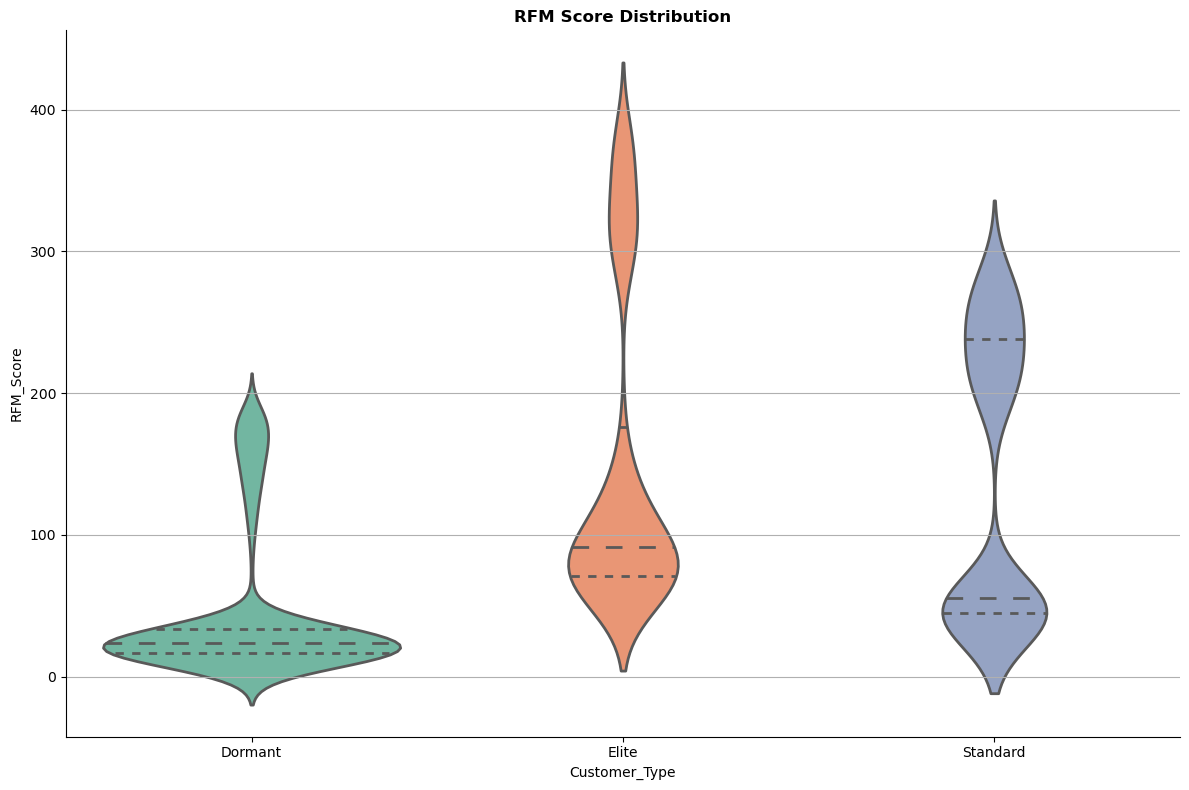

In [15]:
rfm_types_pd = (
    rfm_clusters
    .select("Customer_Type","RFM_Score","Recency","Frequency",
            "Monetary","Log_Frequency","Log_Monetary")
    .limit(200000)
    .toPandas()
)

# ---- RFM Score Violin Plot ----
fig, ax = plt.subplots(figsize=(12, 8))
sns.violinplot(x="Customer_Type", y="RFM_Score",
               data=rfm_types_pd, palette="Set2", inner="quart")
ax.set_title("RFM Score Distribution")
plt.tight_layout()
plt.show()




# Strip plots for Recency, Frequency, Monetary

C:\Users\karne\AppData\Local\Temp\ipykernel_14876\1719214951.py:8: FutureWarning:

Passing `palette` without assigning `hue` is deprecated.

C:\Users\karne\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

C:\Users\karne\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

C:\Users\karne\anaconda3\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

C:\Users\karne\AppData\Local\Temp\ipykernel_14876\1719214951.py:8: FutureWarning:

Passing `palette` without assigning `hue` is deprecated.

C:\Users\karne\anacond

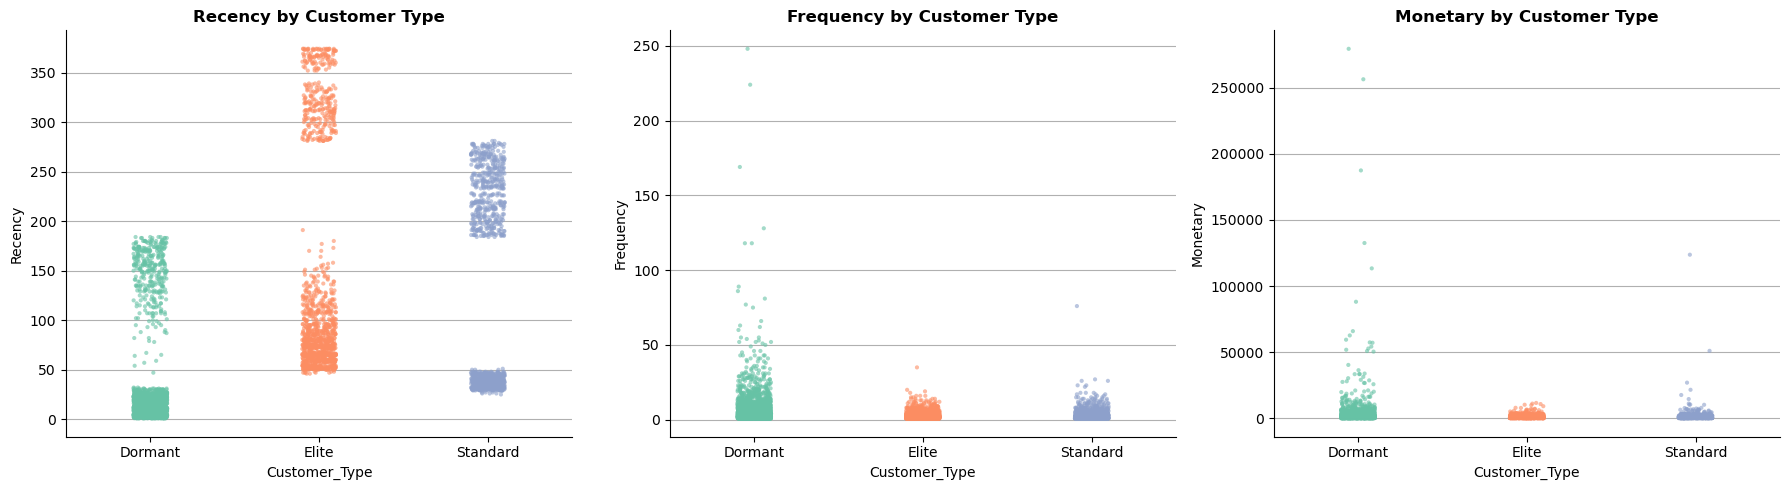

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ["Recency", "Frequency", "Monetary"]
titles = ["Recency by Customer Type", "Frequency by Customer Type", "Monetary by Customer Type"]

for i, metric in enumerate(metrics):
    sns.stripplot(ax=axes[i], data=rfm_types_pd, 
                  x="Customer_Type", y=metric,
                  palette="Set2", jitter=True, alpha=0.6, size=3)
    axes[i].set_title(titles[i])

plt.tight_layout()
plt.show()


# 16) Create churn label and train/test split

In [17]:
rfm_ml = rfm_clusters.withColumn("Churn", ( (col("Recency")>90) | (col("Frequency")<2) ).cast("int"))
train_data, test_data = rfm_ml.select("scaledFeatures","Churn").randomSplit([0.7,0.3], seed=42)
print("Train rows:", train_data.count(), "Test rows:", test_data.count())
train_data.groupBy("Churn").count().show()


Train rows: 3098 Test rows: 1233
+-----+-----+
|Churn|count|
+-----+-----+
|    1| 1420|
|    0| 1678|
+-----+-----+



# 17) Random Forest: CrossValidator with fallback, metrics, ROC

Random Forest AUC: 0.999874075448689
Classification Report:\n               precision    recall  f1-score   support

           0      0.996     0.994     0.995       670
           1      0.993     0.995     0.994       563

    accuracy                          0.994      1233
   macro avg      0.994     0.994     0.994      1233
weighted avg      0.994     0.994     0.994      1233

Confusion Matrix:\n [[666   4]
 [  3 560]]


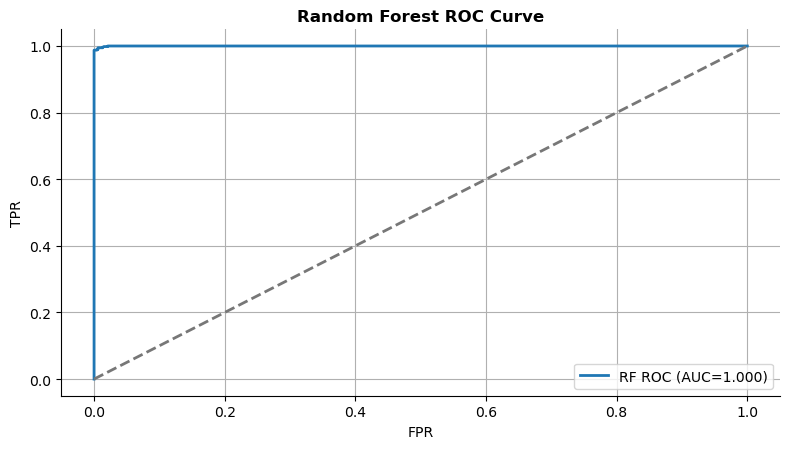

In [18]:
rf = RandomForestClassifier(labelCol="Churn", featuresCol="scaledFeatures", seed=42)

param_grid = (ParamGridBuilder()
              .addGrid(rf.numTrees, [50, 100])
              .addGrid(rf.maxDepth, [5, 7])
              .build())

evaluator = BinaryClassificationEvaluator(labelCol="Churn", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

# Try CV; fallback to single fit if CV fails (common on small datasets or local)
try:
    cv = CrossValidator(estimator=rf, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=3, parallelism=1)
    rf_cv_model = cv.fit(train_data)
    rf_model = rf_cv_model.bestModel
except Exception as e:
    print("CrossValidator failed -- falling back to single RandomForest fit. Exception:", e)
    rf_model = rf.setParams(numTrees=100, maxDepth=7).fit(train_data)

rf_pred = rf_model.transform(test_data)
rf_auc = evaluator.evaluate(rf_pred)
print("Random Forest AUC:", rf_auc)

# Confusion matrix & classification report
rf_pd = rf_pred.withColumn("prob1", vector_to_array("probability").getItem(1)).select("prob1","Churn","prediction").toPandas()
y_true = rf_pd["Churn"].astype(int)
y_pred = rf_pd["prediction"].astype(int)
print("Classification Report:\\n", classification_report(y_true, y_pred, digits=3))
print("Confusion Matrix:\\n", confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, _ = roc_curve(rf_pd["Churn"], rf_pd["prob1"])
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f"RF ROC (AUC={roc_auc:.3f})", color="#1f77b4")
plt.plot([0,1],[0,1], linestyle="--", color="#777777")
plt.title("Random Forest ROC Curve"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.tight_layout(); plt.show()


# 18) Gradient Boosted Trees: CrossValidator with fallback, metrics, ROC

GBT AUC: 0.9998793775350601
Classification Report:\n               precision    recall  f1-score   support

           0      0.995     0.990     0.993       670
           1      0.988     0.995     0.991       563

    accuracy                          0.992      1233
   macro avg      0.992     0.992     0.992      1233
weighted avg      0.992     0.992     0.992      1233

Confusion Matrix:\n [[663   7]
 [  3 560]]


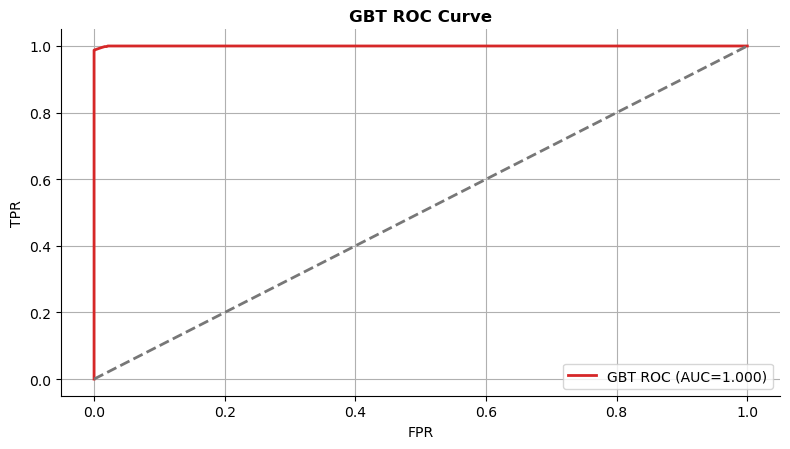

In [20]:
gbt = GBTClassifier(labelCol="Churn", featuresCol="scaledFeatures", seed=42)

param_grid = (ParamGridBuilder()
              .addGrid(gbt.maxIter, [10, 20])
              .addGrid(gbt.maxDepth, [3, 5])
              .build())

evaluator = BinaryClassificationEvaluator(labelCol="Churn", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

try:
    cv = CrossValidator(estimator=gbt, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=3, parallelism=1)
    gbt_cv_model = cv.fit(train_data)
    gbt_model = gbt_cv_model.bestModel
except Exception as e:
    print("GBT CrossValidator failed -- falling back to single GBT fit. Exception:", e)
    gbt_model = gbt.setParams(maxIter=20, maxDepth=5).fit(train_data)

gbt_pred = gbt_model.transform(test_data)
gbt_auc = evaluator.evaluate(gbt_pred)
print("GBT AUC:", gbt_auc)

gbt_pd = gbt_pred.withColumn("prob1", vector_to_array("probability").getItem(1)).select("prob1","Churn","prediction").toPandas()
y_true = gbt_pd["Churn"].astype(int); y_pred = gbt_pd["prediction"].astype(int)
print("Classification Report:\\n", classification_report(y_true, y_pred, digits=3))
print("Confusion Matrix:\\n", confusion_matrix(y_true, y_pred))

fpr, tpr, _ = roc_curve(gbt_pd["Churn"], gbt_pd["prob1"])
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f"GBT ROC (AUC={roc_auc:.3f})", color="#d62728")
plt.plot([0,1],[0,1], linestyle="--", color="#777777")
plt.title("GBT ROC Curve"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.tight_layout(); plt.show()


# END